In [61]:
 ! pip install -q kaggle

In [62]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle (3).json


{'kaggle.json': b'{"username":"parikshitkumar","key":"8ac0ee57845f432b8219e18ca4b87319"}'}

In [63]:
! mkdir ~/.kaggle 

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [64]:
! cp kaggle.json ~/.kaggle/

In [65]:
! chmod 600 ~/.kaggle/kaggle.json

In [66]:
! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


In [67]:
!unzip chest-xray-pneumonia -d train

Archive:  chest-xray-pneumonia.zip
replace train/chest_xray/__MACOSX/._chest_xray? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [68]:
import os
import torch
import torchvision



In [69]:
train_dir ='./train/chest_xray/train/'
val_dir = './train/chest_xray/val/'
test_dir ='./train/chest_xray/test/'
classes = os.listdir(train_dir)
print(classes)





['NORMAL', 'PNEUMONIA']


In [70]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [71]:
import torchvision.transforms as tt

tfms = tt.Compose([tt.Resize((64,64)),
                         tt.ToTensor()])

train_ds = ImageFolder(train_dir,tfms)
val_ds = ImageFolder(val_dir,tfms)

In [72]:
train_ds[0]

(tensor([[[0.0784, 0.1098, 0.2392,  ..., 0.5412, 0.3843, 0.3686],
          [0.0784, 0.0863, 0.2118,  ..., 0.4706, 0.3686, 0.3569],
          [0.0824, 0.0745, 0.1804,  ..., 0.4078, 0.3608, 0.3412],
          ...,
          [0.1098, 0.1098, 0.1020,  ..., 0.0824, 0.0863, 0.0902],
          [0.1098, 0.1059, 0.1020,  ..., 0.1059, 0.1098, 0.1137],
          [0.1333, 0.1294, 0.1255,  ..., 0.2667, 0.2745, 0.2824]],
 
         [[0.0784, 0.1098, 0.2392,  ..., 0.5412, 0.3843, 0.3686],
          [0.0784, 0.0863, 0.2118,  ..., 0.4706, 0.3686, 0.3569],
          [0.0824, 0.0745, 0.1804,  ..., 0.4078, 0.3608, 0.3412],
          ...,
          [0.1098, 0.1098, 0.1020,  ..., 0.0824, 0.0863, 0.0902],
          [0.1098, 0.1059, 0.1020,  ..., 0.1059, 0.1098, 0.1137],
          [0.1333, 0.1294, 0.1255,  ..., 0.2667, 0.2745, 0.2824]],
 
         [[0.0784, 0.1098, 0.2392,  ..., 0.5412, 0.3843, 0.3686],
          [0.0784, 0.0863, 0.2118,  ..., 0.4706, 0.3686, 0.3569],
          [0.0824, 0.0745, 0.1804,  ...,

Label:  NORMAL (0)


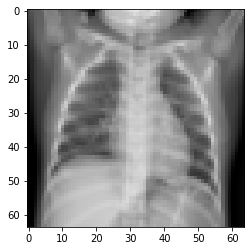

In [73]:
import matplotlib.pyplot as plt

def show_example(img, label):
    print('Label: ', train_ds.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1,2,0))


show_example(*train_ds[23])

In [74]:
from torch.utils.data.dataloader import DataLoader

batch_size=64

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

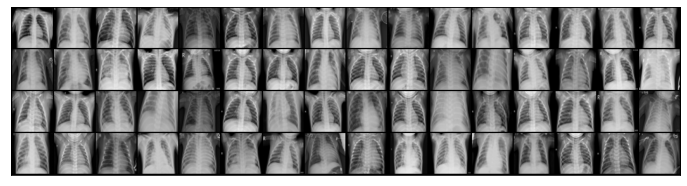

In [75]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1,2,0))
        break
show_batch(train_dl)

In [76]:
import torch.nn as nn
import torch.nn.functional as F

In [77]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [78]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    break

images.shape: torch.Size([64, 3, 64, 64])


In [79]:
class Cnnblock(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 
            '''same padding,32x32x32''' 

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 
            '''same padding,16x16x32'''

            nn.Flatten(), 
            nn.Linear(16*16*32,128),
            nn.ReLU(),
            nn.Linear(128,2))
            
        
    def forward(self, xb):
        return self.network(xb)

In [80]:
model = Cnnblock()
model

Cnnblock(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten()
    (7): Linear(in_features=8192, out_features=128, bias=True)
    (8): ReLU()
    (9): Linear(in_features=128, out_features=2, bias=True)
  )
)

In [81]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([64, 3, 64, 64])
out.shape: torch.Size([64, 2])
out[0]: tensor([-0.0857,  0.0333], grad_fn=<SelectBackward>)


In [82]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [83]:
device = get_default_device()
device

device(type='cuda')

In [84]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

In [85]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [86]:
model = to_device(Cnnblock(), device)

In [87]:
evaluate(model, val_dl)

{'val_acc': 0.5, 'val_loss': 0.6943613886833191}

In [88]:
num_epochs = 3
opt_func = torch.optim.Adam
lr = 0.001

In [89]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.3891, val_loss: 0.4359, val_acc: 0.8750
Epoch [1], train_loss: 0.1488, val_loss: 0.3573, val_acc: 0.9375


KeyboardInterrupt: ignored

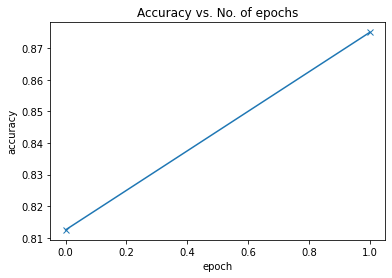

In [90]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
plot_accuracies(history)

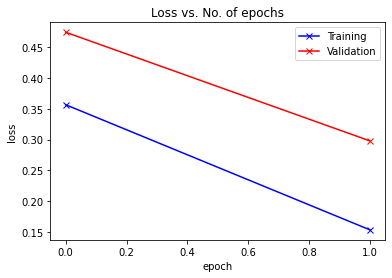

In [91]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)